# FLASH: example GMD correlation 
* commissioning shift at CAMP@FLASH1
* GMD ion signal - slow signal -> 1 value per pulse train
* GMD electron signal - fast signal -> 1 value per pulse (e.g. 400 pulses per train)

In [1]:
%matplotlib inline

In [2]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import kde

plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
run_number = 28496

data_dir = '/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/'
hdf_filename = 'FLASH1_USER1-run'+str(run_number)+'.h5'

gmd_ion_bda_addr = '/FL1/Photon Diagnostic/GMD/Average energy/energy BDA (raw)'
gmd_ion_tunnel_addr = '/FL1/Photon Diagnostic/GMD/Average energy/energy tunnel (raw)'
gmd_electron_bda_addr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy BDA (raw)'
gmd_electron_tunnel_addr = '/FL1/Photon Diagnostic/GMD/Pulse resolved energy/energy tunnel (raw)'

print(data_dir+hdf_filename)

/asap3/fs-flash-o/gpfs/camp/2019/data/11007673/raw/hdf/by-run/FLASH1_USER1-run28496.h5


### Read from hdf5 file 

In [4]:
with h5py.File(data_dir+hdf_filename,'r') as hdf_file:
    gmd_ion_bda = hdf_file[gmd_ion_bda_addr][()]
    gmd_ion_tunnel = hdf_file[gmd_ion_tunnel_addr][()]
    gmd_electron_bda = hdf_file[gmd_electron_bda_addr][()]
    gmd_electron_tunnel = hdf_file[gmd_electron_tunnel_addr][()]

### Visualize 

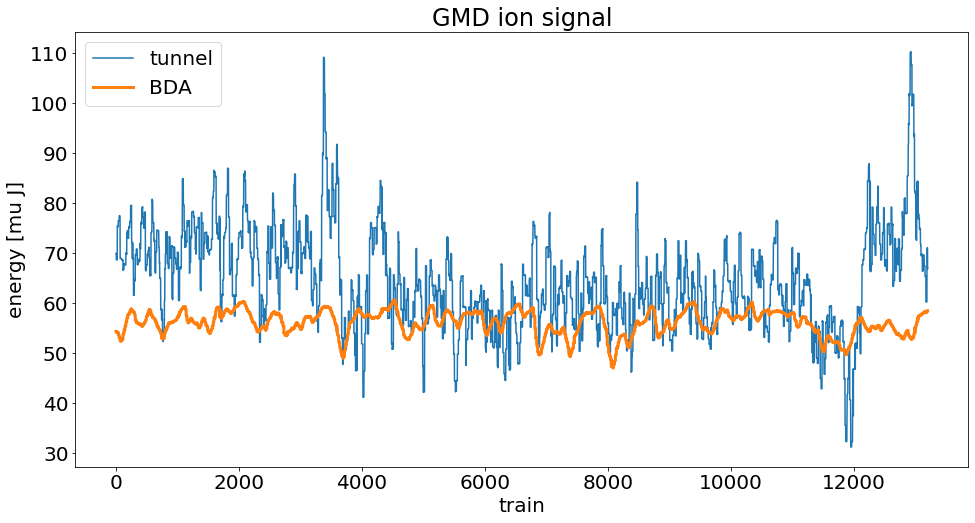

In [5]:
fig = plt.figure()
plt.plot(gmd_ion_tunnel, label = 'tunnel')
plt.plot(gmd_ion_bda, label = 'BDA', lw = 3)
plt.xlabel('train')
plt.ylabel('energy [mu J]')
plt.legend()
plt.title('GMD ion signal')
plt.show()

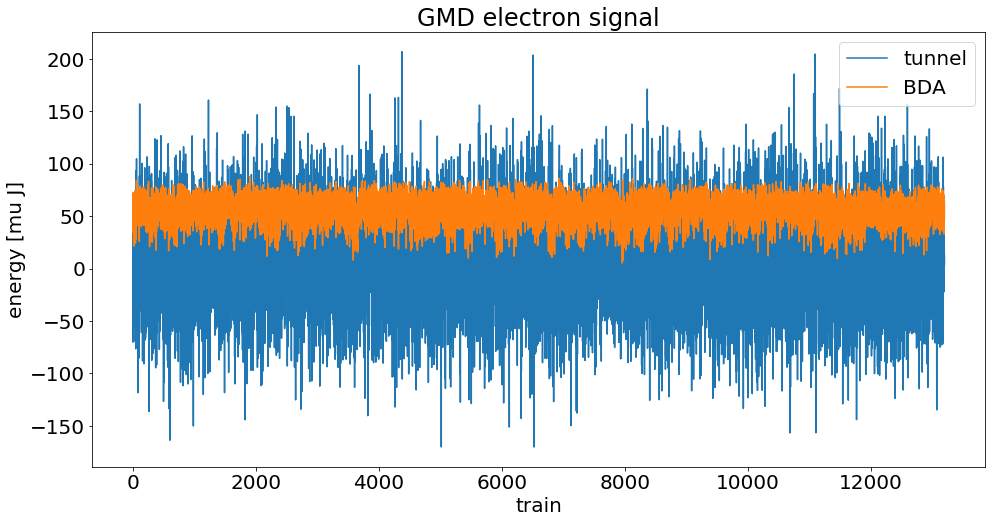

GMD tunnel: electron signal:
total number:  13200
number of values smaller than Zero:  5714
number of NaNs:  5


In [6]:
fig = plt.figure()
plt.plot(gmd_electron_tunnel, label = 'tunnel')
plt.plot(gmd_electron_bda, label = 'BDA')
plt.xlabel('train')
plt.ylabel('energy [mu J]')
plt.legend()
plt.title('GMD electron signal')
plt.show()

print('GMD tunnel: electron signal:')
print('total number: ',len(gmd_electron_tunnel))
print('number of values smaller than Zero: ',len(gmd_electron_tunnel[gmd_electron_tunnel<0]))
print('number of NaNs: ', np.sum(np.isnan(gmd_electron_tunnel)))

### <span style="color:red">negative values for pulse resolved GMD values in tunnel</span>

## distribution of pulse resolved GMD values

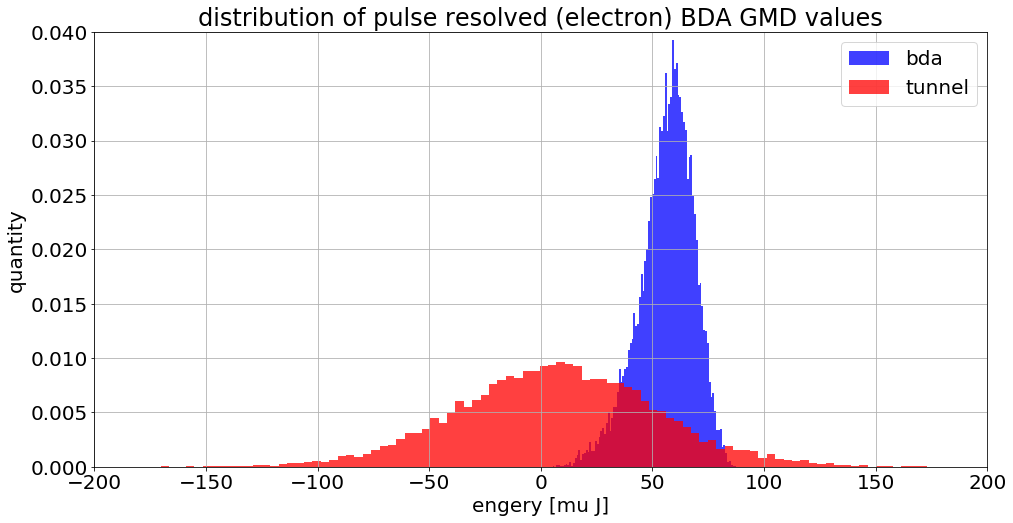

In [7]:
fig = plt.figure()
plt.hist(gmd_electron_bda,100, density= True, facecolor = 'b', alpha=0.75, label = 'bda')
plt.hist(gmd_electron_tunnel,100, density= True, facecolor = 'r', alpha=0.75, label = 'tunnel')
plt.xlabel('engery [mu J]')
plt.ylabel('quantity')
plt.title('distribution of pulse resolved (electron) BDA GMD values')
plt.axis([-200, 200, 0, 0.04])
plt.legend()
plt.grid(True)

### <span style="color:red"> using BDA GMD as the tunnel GMD did not have enough gas pressure </span> 

# GMD Correlations
* not useful in this case 

In [8]:
def calc_density_of_correlation(array_x, array_y, nbins = 300):    
    x = np.asarray([array_x[index] for index in range(len(array_x)) if array_x[index] == array_x[index] and array_y[index] == array_y[index]])
    y = np.asarray([array_y[index] for index in range(len(array_y)) if array_x[index] == array_x[index] and array_y[index] == array_y[index]])
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi.reshape(xi.shape) 

def plot_density_of_correlation(array_x, array_y, nbins = 300):
    x, y, z = calc_density_of_correlation(array_x, array_y, nbins = 300)
    plt.pcolormesh(x,y,z)

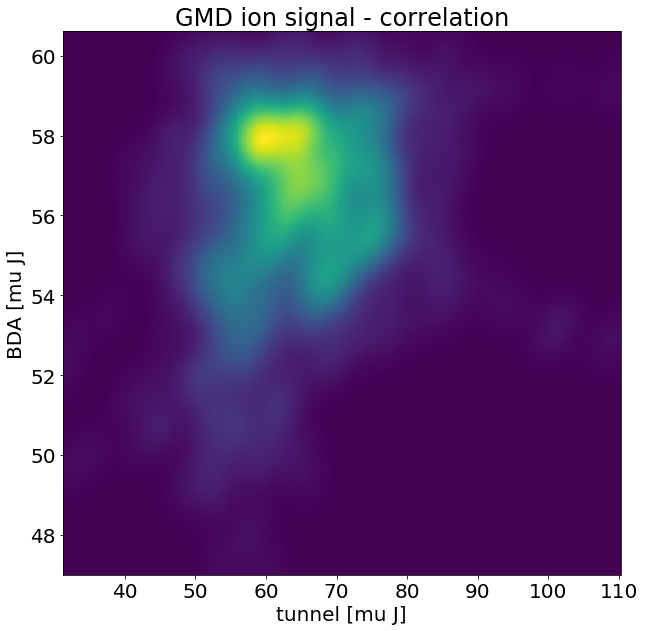

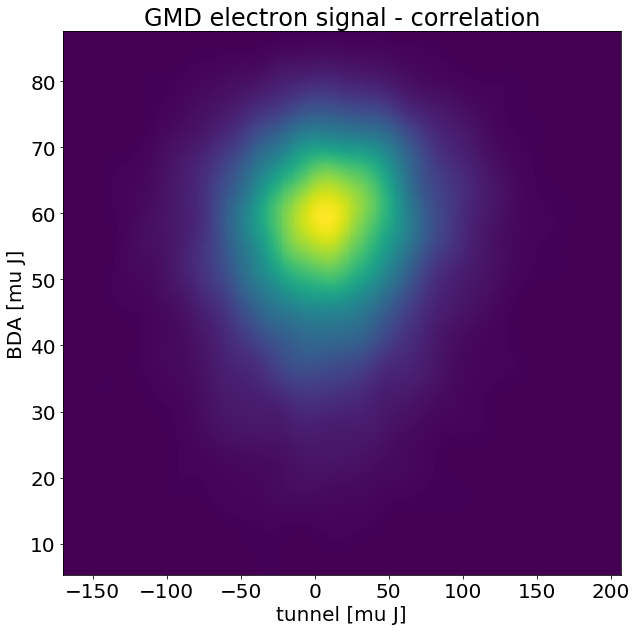

In [9]:
fig = plt.figure(figsize=(10,10))
plot_density_of_correlation(gmd_ion_tunnel.flatten(), gmd_ion_bda.flatten())
plt.xlabel('tunnel [mu J]')
plt.ylabel('BDA [mu J]')
plt.title('GMD ion signal - correlation')

fig = plt.figure(figsize=(10,10))
plot_density_of_correlation(gmd_electron_tunnel.flatten(), gmd_electron_bda.flatten())
plt.xlabel('tunnel [mu J]')
plt.ylabel('BDA [mu J]')
plt.title('GMD electron signal - correlation');

# Compare: electron & ion GMD signal
* use 1st order Bessel filter for electron signal 
* compensate for hardware delay (Keyleigh) by shifting in time  

In [10]:
def bessel_filter(input_array):
    a0 = 0.00500145
    a1 = a0
    b1 = 1 - a0 - a1 
    output_list = [input_array[0]]
    for i in range(1,len(input_array)):
        output_list.append(a0 * input_array[i]+a1*input_array[i-1]+b1*output_list[i-1])
    return np.asarray(output_list)

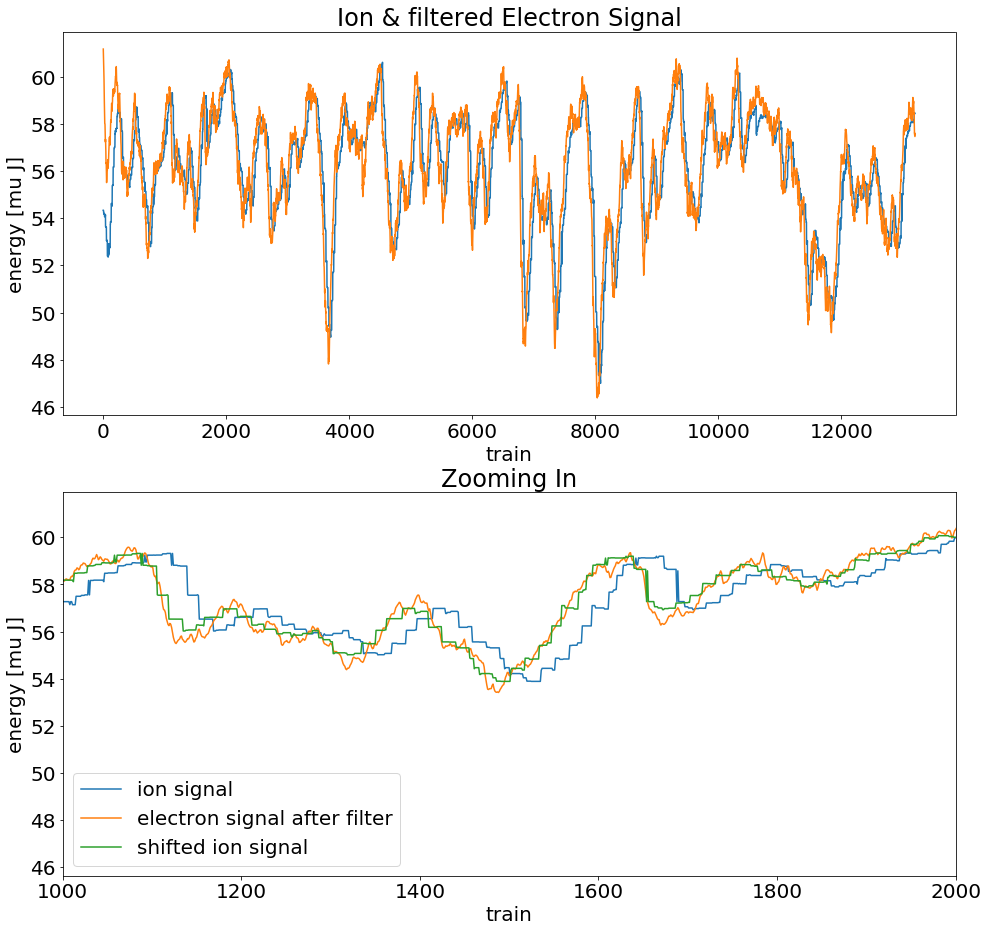

In [11]:
filtered_electron_gmd_bda = bessel_filter(np.nan_to_num(gmd_electron_bda))

shift = -34
shifted_gmd_ion_bda =np.roll(gmd_ion_bda, shift)

plt.figure(figsize=(16,24))
plt.subplot(311)
plt.plot(gmd_ion_bda, label = 'ion signal')
plt.plot(filtered_electron_gmd_bda,  label = 'electron signal after filter')
plt.xlabel('train')
plt.ylabel('energy [mu J]')
plt.title('Ion & filtered Electron Signal')

plt.subplot(312)
plt.plot(gmd_ion_bda, label = 'ion signal')
plt.plot(filtered_electron_gmd_bda,  label = 'electron signal after filter')
plt.plot(shifted_gmd_ion_bda, label = 'shifted ion signal')
plt.xlabel('train')
plt.ylabel('energy [mu J]')
plt.legend()
plt.xlim(1000,2000)
plt.title('Zooming In');

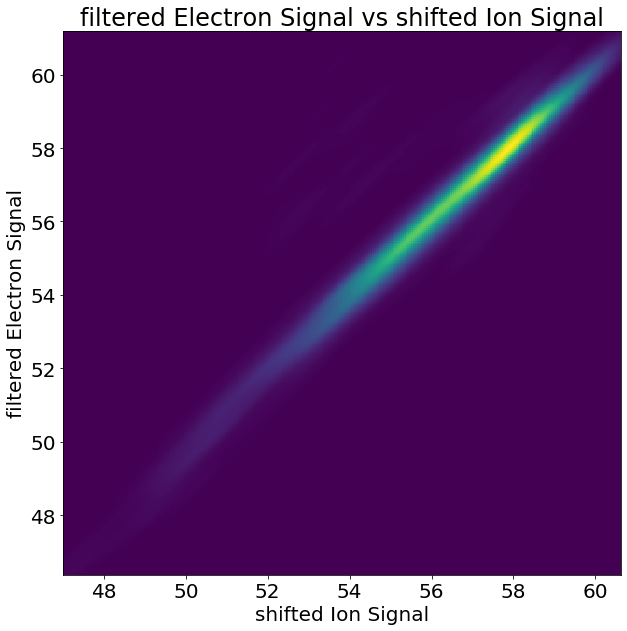

In [13]:
plt.figure(figsize=(10,10))
plot_density_of_correlation(shifted_gmd_ion_bda.flatten(), filtered_electron_gmd_bda.flatten())
plt.xlabel('shifted Ion Signal')
plt.ylabel('filtered Electron Signal')
plt.title('filtered Electron Signal vs shifted Ion Signal');